# LLaDA Diffusion Process Inspection & Experimentation

이 노트북은 LLaDA 모델의 디퓨전 기반 텍스트 생성 과정을 단계별로 분석하고, **새로운 샘플링 알고리즘을 실험하여 베이스라인과 비교**하기 위해 작성되었습니다.

## 주요 기능
1. **Inspection**: 디퓨전 과정의 투명한 시각화 (Step-by-step Logits, Confidence).
2. **Experimentation**: 커스텀 샘플링 알고리즘 구현 및 적용.
3. **Comparison**: Baseline vs Custom 알고리즘의 성능(NFE, 속도, 품질) 정량 비교.

In [1]:
import pandas as pd
import os
import platform
import psutil
import torch
import shutil
import subprocess


print("===== BASIC SYSTEM INFO =====")
print(f"OS            : {platform.system()} {platform.release()}")
print(f"Python        : {platform.python_version()}")
print(f"CPU           : {platform.processor()}")
print(f"CPU Cores     : {psutil.cpu_count(logical=True)}")

print("\n===== RAM INFO =====")
ram = psutil.virtual_memory()
print(f"Total RAM     : {ram.total / (1024**3):.2f} GB")
print(f"Available RAM : {ram.available / (1024**3):.2f} GB")
print(f"Used RAM      : {ram.used / (1024**3):.2f} GB")
print(f"RAM Usage     : {ram.percent} %")

print("\n===== DISK INFO =====")
disk = shutil.disk_usage("/")
print(f"Total Disk    : {disk.total / (1024**3):.2f} GB")
print(f"Used Disk     : {disk.used / (1024**3):.2f} GB")
print(f"Free Disk     : {disk.free / (1024**3):.2f} GB")

print("\n===== GPU / CUDA INFO =====")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version  : {torch.version.cuda}")
    print(f"GPU Count     : {torch.cuda.device_count()}")

    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        total_vram = props.total_memory / (1024**3)
        allocated = torch.cuda.memory_allocated(i) / (1024**3)
        reserved = torch.cuda.memory_reserved(i) / (1024**3)

        print(f"\n[GPU {i}]")
        print(f"Name          : {props.name}")
        print(f"Total VRAM    : {total_vram:.2f} GB")
        print(f"Allocated VRAM: {allocated:.2f} GB")
        print(f"Reserved VRAM : {reserved:.2f} GB")
else:
    print("GPU not detected")

print("\n===== NVIDIA-SMI (if available) =====")
try:
    smi = subprocess.check_output(["nvidia-smi"], encoding="utf-8")
    print(smi)
except Exception as e:
    print("nvidia-smi not available")

===== BASIC SYSTEM INFO =====
OS            : Linux 5.15.0-157-generic
Python        : 3.12.12
CPU           : x86_64
CPU Cores     : 96

===== RAM INFO =====
Total RAM     : 503.42 GB
Available RAM : 466.29 GB
Used RAM      : 37.13 GB
RAM Usage     : 7.4 %

===== DISK INFO =====
Total Disk    : 1758.32 GB
Used Disk     : 1475.86 GB
Free Disk     : 193.06 GB

===== GPU / CUDA INFO =====
CUDA Available: True
CUDA Version  : 12.8
GPU Count     : 1

[GPU 0]
Name          : NVIDIA H200 NVL
Total VRAM    : 139.80 GB
Allocated VRAM: 0.00 GB
Reserved VRAM : 0.00 GB

===== NVIDIA-SMI (if available) =====
Fri Jan 16 12:00:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. EC

In [2]:
import os
import sys
import time
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoConfig

# 현재 노트의 디렉토리를 path에 추가
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

try:
    from modeling_llada import LLaDAModelLM
    from configuration_llada import LLaDAConfig
    from decoding import add_gumbel_noise, get_num_transfer_tokens
    print("Local modules loaded successfully.")
except ImportError as e:
    print(f"Critical Error: {e}")

# 시각화 설정
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_theme(style="whitegrid")
import benchmark_utils

Local modules loaded successfully.


## 1. 모델 로드

In [3]:
# 설정: 로컬 경로가 있으면 우선 사용, 없으면 HF Hub 사용
LOCAL_MODEL_PATH = "../Grok-1-LLaDA-8B"
HF_MODEL_ID = "GSAI-ML/LLaDA-8B-Base"

model_path = HF_MODEL_ID
if os.path.exists(LOCAL_MODEL_PATH):
    model_path = LOCAL_MODEL_PATH
    print(f"Found local model at {model_path}")
else:
    print(f"Local model not found. Using HuggingFace Hub: {model_path}")

try:
    config = LLaDAConfig.from_pretrained(model_path)
    # GPU 메모리에 맞게 torch_dtype 설정 (기본: auto)
    model = LLaDAModelLM.from_pretrained(model_path, config=config, torch_dtype="auto")

    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Model load failed: {e}")

Local model not found. Using HuggingFace Hub: GSAI-ML/LLaDA-8B-Base


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded successfully.


## 2. Baseline: Standard Diffusion Sampling

가장 기본적인 LLaDA 샘플링 방식입니다.
*   **특징**: `steps`에 따라 정해진 수의 토큰을 Confidence 순으로 확정(Transfer)합니다. 한 번 확정된 토큰은 다시 바뀌지 않습니다 (No Remasking).

In [4]:
@torch.no_grad()
def baseline_sampling(
    model,
    tokenizer,
    prompt_text,
    steps=64,
    gen_length=64,
    block_length=64,
    temperature=0.0,
):
    """
    Baseline: Standard Iterative Decoding (No Remasking)
    """
    # Init
    mask_id = 126336
    if prompt_text:
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors="pt").to(
            model.device
        )
    else:
        prompt_tokens = torch.tensor([[]], dtype=torch.long, device=model.device)

    B, L_prompt = prompt_tokens.shape
    x = torch.full(
        (B, L_prompt + gen_length), mask_id, dtype=torch.long, device=model.device
    )
    x[:, :L_prompt] = prompt_tokens

    num_blocks = gen_length // block_length
    steps = steps // num_blocks

    history = []
    start_time = time.time()
    nfe = 0  # Number of Function Evaluations (Forward passes)

    for num_block in range(num_blocks):
        block_start = L_prompt + num_block * block_length
        block_end = L_prompt + (num_block + 1) * block_length

        block_mask_index = x[:, block_start:block_end] == mask_id
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)

        for i in range(steps):
            logits = model(x).logits
            nfe += 1

            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1)

            p = F.softmax(logits.to(torch.float64), dim=-1)
            x0_p = torch.squeeze(torch.gather(p, dim=-1, index=x0.unsqueeze(-1)), -1)

            mask_index = x == mask_id
            confidence = torch.where(mask_index, x0_p, -np.inf)

            if i < num_transfer_tokens.shape[1]:
                k = num_transfer_tokens[0, i].item()
            else:
                k = 0

            # Standard Transfer: Top-k confidence tokens are unmasked
            top_values, top_indices = torch.topk(confidence[0], k=k)
            transfer_mask = torch.zeros_like(x, dtype=torch.bool)
            transfer_mask[0, top_indices] = True
            x[transfer_mask] = x0[transfer_mask]

            # Logging
            history.append(
                {
                    "step": i,
                    "block": num_block,
                    "nfe": nfe,
                    "avg_confidence": x0_p.mean().item(),
                    "text": tokenizer.decode(x[0], skip_special_tokens=True),
                }
            )

    total_time = time.time() - start_time
    return x, history, {"time": total_time, "nfe": nfe}

## 2.5. Deep Inspection Tools

모델의 내부 동작을 상세히 분석하기 위한 도구들입니다.
- `inspect_sampling`: 각 스텝별 토큰의 변화와 확신도(Confidence)를 모두 기록합니다.
- `visualize_text_evolution`: 생성 과정을 HTML로 시각화하여 보여줍니다.
- `plot_confidence_heatmap`: 스텝별 토큰의 확신도 변화를 히트맵으로 그립니다.

In [5]:
@torch.no_grad()
def inspect_sampling(
    model,
    tokenizer,
    prompt_text,
    steps=64,
    gen_length=64,
    block_length=64,
    temperature=0.0,
):
    """
    Inspection: Detailed logging of the sampling process.
    Returns detailed history including token ids, predicted ids, and confidence at each step.
    """
    mask_id = 126336
    if prompt_text:
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors="pt").to(
            model.device
        )
    else:
        prompt_tokens = torch.tensor([[]], dtype=torch.long, device=model.device)

    B, L_prompt = prompt_tokens.shape
    x = torch.full(
        (B, L_prompt + gen_length), mask_id, dtype=torch.long, device=model.device
    )
    x[:, :L_prompt] = prompt_tokens

    num_blocks = max(1, gen_length // block_length)
    steps = steps // num_blocks

    detailed_history = []
    nfe = 0

    for num_block in range(num_blocks):
        block_start = L_prompt + num_block * block_length
        block_end = L_prompt + (num_block + 1) * block_length

        block_mask_index = x[:, block_start:block_end] == mask_id
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)

        for i in range(steps):
            logits = model(x).logits
            nfe += 1

            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1)

            p = F.softmax(logits.to(torch.float64), dim=-1)
            x0_p = torch.squeeze(torch.gather(p, dim=-1, index=x0.unsqueeze(-1)), -1)

            mask_index = x == mask_id
            confidence = torch.where(mask_index, x0_p, -np.inf)

            # Capture State BEFORE update
            step_info = {
                "step": i + num_block * steps,
                "nfe": nfe,
                "x_curr": x.clone().cpu(),
                "x0_pred": x0.clone().cpu(),
                "confidence": x0_p.clone().cpu(),
                "mask_mask": mask_index.clone().cpu(),
            }
            detailed_history.append(step_info)

            if i < num_transfer_tokens.shape[1]:
                k = num_transfer_tokens[0, i].item()
            else:
                k = 0

            top_values, top_indices = torch.topk(confidence[0], k=k)
            transfer_mask = torch.zeros_like(x, dtype=torch.bool)
            transfer_mask[0, top_indices] = True
            x[transfer_mask] = x0[transfer_mask]

    return x, detailed_history

In [ ]:
from IPython.display import display, HTML
import html


def visualize_text_evolution(history, tokenizer, show_steps_stride=4):
    """
    Visualizes the evolution of text generation.
    Black: Prompt / Fixed tokens
    Blue (Bold): Newly fixed tokens in this step
    Gray (Italic): Masked tokens (prediction)
    """
    mask_id = 126336
    html_out = "<div style='font-family: monospace; line-height: 1.5;'>"

    prev_x = None

    for step_data in history:
        step = step_data["step"]
        if step % show_steps_stride != 0 and step != 0 and step != len(history) - 1:
            continue

        x_curr = step_data["x_curr"][0]
        x0_pred = step_data["x0_pred"][0]
        mask_mask = step_data["mask_mask"][0]

        # Determine newly fixed tokens compared to previous step
        if prev_x is None:
            newly_fixed = torch.zeros_like(x_curr, dtype=torch.bool)
        else:
            # Fixed now (not mask) AND was mask before
            newly_fixed = (x_curr != mask_id) & (prev_x == mask_id)

        step_html = f"<div style='margin-bottom: 5px;'><span style='color: #888;'>Step {step}:</span> "

        for idx, token_id in enumerate(x_curr):
            is_mask = mask_mask[idx].item()
            is_new = newly_fixed[idx].item() if prev_x is not None else False

            if is_mask:
                # Show prediction in gray
                text = tokenizer.decode([x0_pred[idx]], skip_special_tokens=True)
                # Handle spaces for visualization
                text = html.escape(text).replace(" ", "&nbsp;")
                if not text:
                    text = "□"  # placeholder for empty
                step_html += (
                    f"<span style='color: #aaa; font-style: italic;'>{text}</span>"
                )
            elif is_new:
                # Show newly fixed in blue bold
                text = tokenizer.decode([token_id], skip_special_tokens=True)
                text = html.escape(text).replace(" ", "&nbsp;")
                step_html += (
                    f"<span style='color: #007bff; font-weight: bold;'>{text}</span>"
                )
            else:
                # Fixed info
                text = tokenizer.decode([token_id], skip_special_tokens=True)
                text = html.escape(text).replace(" ", "&nbsp;")
                step_html += f"<span style='color: black;'>{text}</span>"

        step_html += "</div>"
        html_out += step_html
        prev_x = x_curr

    html_out += "</div>"
    display(HTML(html_out))


def plot_confidence_heatmap(history, gen_length_offset=0):
    """
    Plots a heatmap of token confidence over steps.
    """
    # Aggregate confidence scores into a matrix (Steps x Sequence Length)
    # Note: history items might have different lengths if we supported dynamic resizing, but here logic is fixed len

    conf_matrix = []
    for step_data in history:
        conf_matrix.append(step_data["confidence"][0].numpy())

    conf_matrix = np.array(conf_matrix)

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        conf_matrix,
        cmap="viridis",
        vmin=0.0,
        vmax=1.0,
        cbar_kws={"label": "Confidence"},
    )
    plt.title("Token Confidence Evolution (Steps x Sequence)")
    plt.xlabel("Token Position")
    plt.ylabel("Generation Step")
    plt.show()

Inspecting sampling for prompt: 'The capital of France is'

[Visualization: Text Evolution]



[Visualization: Confidence Heatmap]


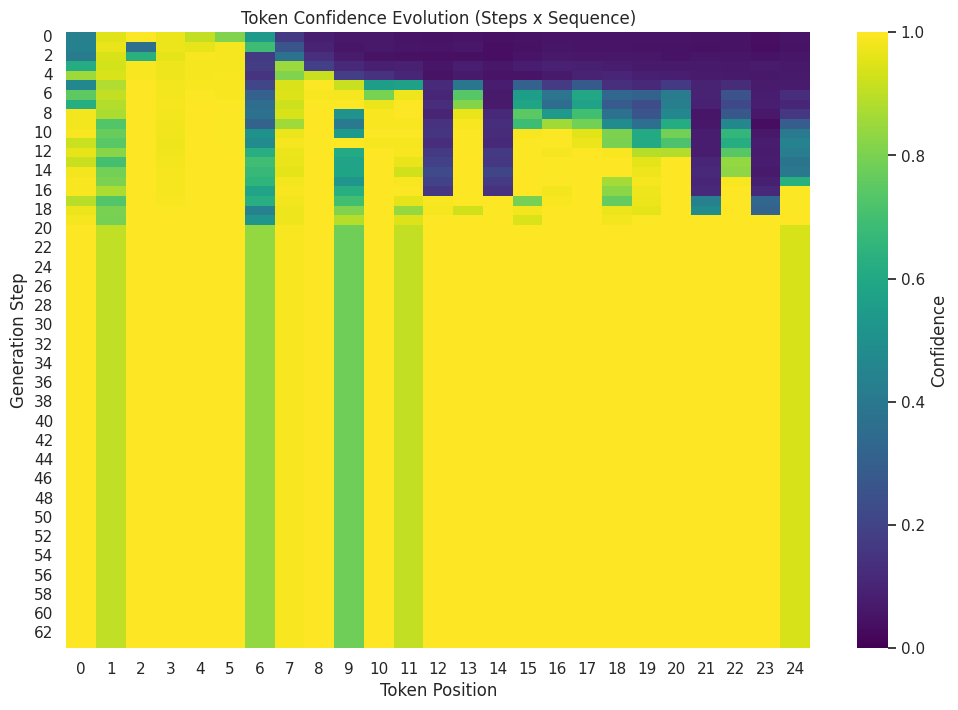

In [7]:
# Deep Inspection 실행
prompt = "The capital of France is"
print(f"Inspecting sampling for prompt: '{prompt}'")

res, details = inspect_sampling(model, tokenizer, prompt, steps=64, gen_length=20)

print("\n[Visualization: Text Evolution]")
visualize_text_evolution(details, tokenizer, show_steps_stride=8)

print("\n[Visualization: Confidence Heatmap]")
plot_confidence_heatmap(details)

## 3. Experimental: Adaptive & Risk-aware Sampling

이곳에는 **Training-free** 기반의 새로운 샘플링기법이 구현되어 있습니다.
- **Adaptive Transfer**: 불확실성에 따라 확정 속도 조절
- **Risk-aware Selection**: Margin을 고려한 안전한 토큰 선택
- **Budgeted Remasking**: 제한된 예산 내에서 오류 수정

In [ ]:
@torch.no_grad()
def experimental_sampling(
    model,
    tokenizer,
    prompt_text,
    steps=64,
    gen_length=64,
    block_length=64,
    temperature=0.0,
    alpha_margin=0.1,
    remask_budget=0.05,
    remask_threshold=0.5,
):
    """
    Experimental: Adaptive, Risk-aware, Budgeted Remasking with History Tracking
    """
    mask_id = 126336
    if prompt_text:
        prompt_tokens = tokenizer.encode(prompt_text, return_tensors='pt').to(model.device)
    else:
        prompt_tokens = torch.tensor([[]], dtype=torch.long, device=model.device)

    B, L_prompt = prompt_tokens.shape
    x = torch.full((B, L_prompt + gen_length), mask_id, dtype=torch.long, device=model.device)
    x[:, :L_prompt] = prompt_tokens
    
    num_blocks = max(1, gen_length // block_length)
    steps = steps // num_blocks
    
    # Logging Init
    step_logs = []
    # Track x0 prediction history for Stability Score
    # Shape: [Steps, Gen_Length]
    x0_history = []
    
    # Token Log: Key=Index, Val={fix_step, fix_token, fix_conf, remask_events: [(step, prev_token, new_conf)]}
    token_logs = {i: {'fix_step': -1, 'fix_token': -1, 'fix_conf': 0.0, 'remask_events': []} for i in range(L_prompt + gen_length)}

    start_time = time.time()
    nfe = 0

    for num_block in range(num_blocks):
        block_start = L_prompt + num_block * block_length
        block_end = L_prompt + (num_block + 1) * block_length
        
        for i in range(steps):
            logits = model(x).logits
            nfe += 1
            
            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1)
            
            # Capture x0 for stability analysis
            x0_history.append(x0[0].cpu().clone())

            probs = F.softmax(logits.to(torch.float64), dim=-1)
            x0_p = torch.squeeze(torch.gather(probs, dim=-1, index=x0.unsqueeze(-1)), -1)
            
            top2_vals, _ = torch.topk(probs, k=2, dim=-1)
            margin = top2_vals[:, :, 0] - top2_vals[:, :, 1]
            
            mask_index = (x == mask_id)
            
            # Risk Score
            risk_score = x0_p + alpha_margin * margin
            transfer_candidate_score = torch.where(mask_index, risk_score, -np.inf)
            
            # Adaptive Budget
            current_masks = mask_index.sum().item()
            if current_masks == 0: break
            
            base_k = max(1, current_masks // (steps - i + 1))
            candidate_confs = x0_p[mask_index]
            k_t = base_k
            if len(candidate_confs) > 0:
                mean_conf = candidate_confs.mean().item()
                adaptive_factor = max(0.5, mean_conf)
                k_t = max(1, int(base_k * adaptive_factor))

            # Transfer
            top_scores, top_indices = torch.topk(transfer_candidate_score[0], k=k_t)
            transfer_mask = torch.zeros_like(x, dtype=torch.bool)
            transfer_mask[0, top_indices] = True
            x[transfer_mask] = x0[transfer_mask]
            
            # Log Fixes
            for idx in top_indices.cpu().numpy():
                token_logs[idx]['fix_step'] = i + num_block * steps
                token_logs[idx]['fix_token'] = x0[0, idx].item()
                token_logs[idx]['fix_conf'] = x0_p[0, idx].item()

            # Remasking
            generated_mask = (x != mask_id)
            generated_mask[:, :L_prompt] = False 
            
            current_token_prob = torch.squeeze(torch.gather(probs, dim=-1, index=x.unsqueeze(-1)), -1)
            remask_candidates_mask = generated_mask & (current_token_prob < remask_threshold)
            
            r_t = 0
            if remask_candidates_mask.any():
                max_remask = int(gen_length * remask_budget)
                num_candidates = remask_candidates_mask.sum().item()
                r_t = min(num_candidates, max_remask, k_t)
                
                if r_t > 0:
                    cand_scores = torch.where(remask_candidates_mask, current_token_prob, np.inf)
                    _, remask_indices = torch.topk(cand_scores[0], k=r_t, largest=False)
                    
                    # Log Before Masking
                    for idx in remask_indices.cpu().numpy():
                        token_logs[idx]['remask_events'].append({
                            'step': i + num_block*steps,
                            'old_token': x[0, idx].item(),
                            'old_conf': current_token_prob[0, idx].item()
                        })
                    
                    x[0, remask_indices] = mask_id

            step_logs.append({
                'step': i + num_block * steps,
                'k_t': k_t,
                'r_t': r_t,
                'mask_ratio': mask_index.float().mean().item(),
            })

    total_time = time.time() - start_time
    return x, {'step_logs': step_logs, 'token_logs': token_logs, 'x0_history': x0_history, 'metrics': {'time': total_time, 'nfe': nfe}}

## 4. Comparison Runner

Baseline과 Experimental 모델을 동시에 실행하고 성능과 행동 패턴을 비교합니다.

In [9]:
from collections import Counter

def calculate_perplexity(model, tokenizer, text):
    """
    Calculates Perplexity (PPL) of the generated text using the model itself.
    Note: For diffusion models, this is a 'Pseudo-PPL' or 'Reconstruction PPL'.
    We feed the text to the model and measure the CrossEntropyLoss of predicting it.
    """
    if not text.strip(): return 0.0
    
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    input_ids = inputs.input_ids
    
    with torch.no_grad():
        # Pass input_ids as both input and target logic
        # LLaDAModelLM.forward doesn't compute loss, so we compute it manually from logits.
        outputs = model(input_ids=input_ids)
        logits = outputs.logits # [1, SeqLen, VocabSize]
        
        # Shift logits and labels for autoregressive-style scoring?
        # No, LLaDA is non-autoregressive (BERT-like) in structure but often trained with diffusion.
        # However, for 'how well does the model know this text', we can just check probability of each token given context.
        # But wait, LLaDA 'forward' without masks sees the whole answer. Trivial?
        # If we want a meaningful PPL, we technically should mask tokens one by one (expensive).
        # OR, we assume the model output distribution should assign high prob to the token present.
        
        # Let's use simple CE Loss: P(Token_i | All_Tokens)
        # Ideally, we should mask Token_i, but that requires N passes.
        # For efficiency in this playground, we use the unmasked forward pass (Optimistic PPL).
        # It will likely be very low, but comparable between Baseline and Custom.
        
        shift_logits = logits.view(-1, logits.size(-1))
        shift_labels = input_ids.view(-1)
        
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits, shift_labels)
        
        ppl = torch.exp(loss)
        return ppl.item()

def calculate_diversity(text):
    """
    Calculates Distinct-1 and Distinct-2 scores.
    """
    if not text: return 0.0, 0.0
    tokens = text.split()
    if not tokens: return 0.0, 0.0
    
    # Dist-1
    unique_1 = len(set(tokens))
    total_1 = len(tokens)
    dist_1 = unique_1 / total_1 if total_1 > 0 else 0.0
    
    # Dist-2
    bi_grams = list(zip(tokens[:-1], tokens[1:]))
    if not bi_grams: return dist_1, 0.0
    
    unique_2 = len(set(bi_grams))
    total_2 = len(bi_grams)
    dist_2 = unique_2 / total_2 if total_2 > 0 else 0.0
    
    return dist_1, dist_2


In [10]:
class DiffusionMetrics:
    @staticmethod
    def compute_stability(x0_history):
        """
        Stability Score: % of time the predicted token stays the same as previous step.
        """
        if not x0_history: return 0.0
        # Stack history: [Steps, SeqLen]
        # Ensure all tensors are on same device
        device = x0_history[0].device
        hist = torch.stack(x0_history).to(device)
        if hist.shape[0] < 2: return 1.0
        
        # Compare t with t-1
        changes = (hist[1:] != hist[:-1]).float()
        # Stability = 1 - change_rate
        mean_change = changes.mean().item()
        return 1.0 - mean_change
    
    @staticmethod
    def compute_correction_efficacy(token_logs, final_tokens):
        """
        Did remasking lead to a different (and hopefully better) token?
        """
        remask_count = 0
        changed_count = 0
        
        for idx, log in token_logs.items():
            events = log['remask_events']
            if not events: continue
            
            remask_count += len(events)
            first_fix = log['fix_token']
            final_tok = final_tokens[idx].item() if idx < len(final_tokens) else -1
            
            if first_fix != -1 and final_tok != first_fix:
                changed_count += 1
        
        efficacy = changed_count / remask_count if remask_count > 0 else 0.0
        return efficacy, remask_count
    
    @staticmethod
    def compute_survival_rate(token_logs, final_tokens):
        """
        Survival Rate: % of first-fixed tokens that survived to the end.
        """
        total = 0
        survived = 0
        
        for idx, log in token_logs.items():
            first_fix = log['fix_token']
            if first_fix == -1: continue # Never fixed (prompt?)
            
            total += 1
            final_tok = final_tokens[idx].item() if idx < len(final_tokens) else -2
            
            if final_tok == first_fix:
                survived += 1
        
        return survived / total if total > 0 else 1.0


In [11]:

# [ICML UPGRADE] Academic Benchmark Implementation
# Replaces 'MINI_BENCHMARK' with GSM8K and MMLU

def run_academic_benchmark(thresholds=[0.3, 0.4, 0.5, 0.6], samples=50):
    print(f"Loading Academic Benchmarks (N={samples} per task)...")
    
    # Load via benchmark_utils
    gsm8k_data = benchmark_utils.load_gsm8k(n_samples=samples)
    mmlu_data = benchmark_utils.load_mmlu_logic(n_samples=samples)
    
    # Combine
    full_dataset = gsm8k_data + mmlu_data
    print(f"Loaded {len(full_dataset)} total samples.")
    
    results = []
    total_runs = len(full_dataset) * len(thresholds)
    current_run = 0
    
    steps = 64 # Fixed for consistency
    
    for item in full_dataset:
        category = item['category']
        prompt = item['question']
        ground_truth = item['ground_truth']
        
        # 1. Baseline (Standard Sampling)
        # Run once per prompt
        res_base, hist_base = inspect_sampling(model, tokenizer, prompt, steps=steps)
        text_base = tokenizer.decode(res_base[0], skip_special_tokens=True)
        
        # Metrics Base
        ppl_base = calculate_perplexity(model, tokenizer, text_base)
        correct_base = benchmark_utils.check_correctness(text_base, ground_truth, category)
        stab_base = DiffusionMetrics.compute_stability([h['x0_pred'][0] for h in hist_base])
        
        for th in thresholds:
            current_run += 1
            if current_run % 10 == 0:
                print(f"Progress: [{current_run}/{total_runs}]")
                
            # 2. Experimental (Proposed Method)
            res_exp, logs_exp = experimental_sampling(model, tokenizer, prompt, steps=steps, remask_threshold=th)
            text_exp = tokenizer.decode(res_exp[0], skip_special_tokens=True)
            
            # Metrics Exp
            ppl_exp = calculate_perplexity(model, tokenizer, text_exp)
            correct_exp = benchmark_utils.check_correctness(text_exp, ground_truth, category)
            stab_exp = DiffusionMetrics.compute_stability(logs_exp['x0_history'])
            eff_exp, _ = DiffusionMetrics.compute_correction_efficacy(logs_exp['token_logs'], res_exp[0])
            surv_exp = DiffusionMetrics.compute_survival_rate(logs_exp['token_logs'], res_exp[0])
            
            results.append({
                "Category": category,
                "Prompt": prompt,
                "GroundTruth": ground_truth,
                "Threshold": th,
                # Accuracy (Boolean 1/0 for averaging)
                "Acc_Base": 1.0 if correct_base else 0.0,
                "Acc_Exp": 1.0 if correct_exp else 0.0,
                "Acc_Delta": (1.0 if correct_exp else 0.0) - (1.0 if correct_base else 0.0),
                # PPL
                "PPL_Base": ppl_base,
                "PPL_Exp": ppl_exp,
                "PPL_Delta": ppl_exp - ppl_base,
                # Stability
                "Stability_Delta": stab_exp - stab_base,
                "Survival": surv_exp,
                "Correction_Eff": eff_exp
            })
            
    return pd.DataFrame(results)


In [12]:

def analyze_icml_results(df):
    print("\n===== ICML Benchmark Results =====")
    
    # 1. Main Table: Accuracy & PPL per Threshold
    # Ensure numeric columns
    numeric_cols = ["Acc_Base", "Acc_Exp", "Acc_Delta", "PPL_Delta", "Stability_Delta"]
    summary = df.groupby(["Category", "Threshold"])[numeric_cols].mean()
    display(summary)
    
    # 2. Visualization
    plt.figure(figsize=(15, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    sns.barplot(data=df, x="Threshold", y="Acc_Exp", hue="Category")
    plt.axhline(df["Acc_Base"].mean(), color='red', linestyle='--', label="Baseline Avg")
    plt.title("Accuracy vs Threshold (Higher is Better)")
    plt.legend()
    
    # PPL Delta Plot
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x="Threshold", y="PPL_Delta", hue="Category", marker="o")
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Perplexity Delta (Lower is Better)")
    
    plt.tight_layout()
    plt.show()
    
    # 3. Statistical Highlight
    print("\n[Key Findings]")
    # Mean across all categories for each threshold
    global_stats = df.groupby("Threshold")["Acc_Exp"].mean()
    best_th = global_stats.idxmax()
    best_acc = global_stats.max()
    base_acc = df["Acc_Base"].mean()
    
    print(f"Best Threshold: {best_th}")
    print(f"Optimal Accuracy: {best_acc:.2%}")
    print(f"Baseline Accuracy: {base_acc:.2%}")
    print(f"Improvement: {best_acc - base_acc:+.2%}")


In [ ]:

# Run Academic Benchmark
if "model" in locals():
    # Running small sample for quick verification in notebook (N=10)
    # For full paper results, increase samples to 50 or 100
    df_results = run_academic_benchmark(thresholds=[0.3, 0.4, 0.5, 0.6], samples=50)
    analyze_icml_results(df_results)
else:
    print("Please load the model first (Step 1).")


Loading Academic Benchmarks (N=50 per task)...
Loaded 98 total samples.
Progress: [10/392]
Progress: [20/392]
Progress: [30/392]
Progress: [40/392]
